In [1]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import shuffle
from scipy.misc import imread
from scipy.misc import imresize
import tensorflow as tf
import random

from ssd import SSD300
from ssd_training import MultiboxLoss
from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))
# some constants
NUM_CLASSES = 21  #もともと4
input_shape = (300, 300, 3)

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
priors = pickle.load(open('prior_boxes_ssd300.pkl', 'rb') )
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [3]:
#  keysにはfilenameに書かれてある画像名が出力される！

# 変更箇所二つのうち一つ目
#################################################################################
#  ここにXML_pkl.pyで保存したものを入れる!!!!
gt = pickle.load(open('/Users/user/SSD/12moji_menkyo.pkl', 'rb'))
##################################################################################




keys = sorted(gt.keys())
print(keys)



num_train =( len(keys) - 2)


#  ランダムに学習用とテスト用に分ける
list_idx = list(range(0,len(keys)))
train_idx = random.sample(list_idx, num_train)
print(train_idx)
test_idx = set(list_idx) - set(train_idx)
test_idx = list(test_idx)
print(test_idx)

#  全てtrain_keysに入れてval_keysを空にすると学習が止まる
train_keys = []
val_keys = []
for tr_idx in train_idx:
    train_keys.append(keys[tr_idx])
for vl_idx in test_idx:
    val_keys.append(keys[vl_idx])


#train_keys = keys[:num_train]
print('train_keys',train_keys)
print('train_keysの数：',len(train_keys))
#val_keys = keys[num_train:]
print('val_keys',val_keys)
#num_val = len(val_keys)

['-25.jpg', '-50.jpg', '0.jpg', '25.jpg', '50.jpg', '75.jpg', 'menkyo12.jpg', 'menkyo2.jpg', 'menkyo3.jpg', 'menkyo4.jpg', 'menkyo5.jpg', 'menkyo6.jpg', 'menkyo9.jpg']
[4, 0, 9, 5, 12, 3, 1, 8, 7, 10, 2]
[11, 6]
train_keys ['50.jpg', '-25.jpg', 'menkyo4.jpg', '75.jpg', 'menkyo9.jpg', '25.jpg', '-50.jpg', 'menkyo3.jpg', 'menkyo2.jpg', 'menkyo5.jpg', '0.jpg']
train_keysの数： 11
val_keys ['menkyo6.jpg', 'menkyo12.jpg']


In [4]:

class Generator(object):
    def __init__(self, gt, bbox_util,
                 batch_size, path_prefix,
                 train_keys, val_keys, image_size,
                 saturation_var=0.5,
                 brightness_var=0.5,
                 contrast_var=0.5,
                 lighting_std=0.5,
                 hflip_prob=0.5,
                 vflip_prob=0.5,
                 do_crop=True,
                 crop_area_range=[0.75, 1.0],
                 aspect_ratio_range=[3./4., 4./3.]):
        self.gt = gt
        self.bbox_util = bbox_util
        self.batch_size = batch_size
        self.path_prefix = path_prefix
        self.train_keys = train_keys
        self.val_keys = val_keys
        self.train_batches = len(train_keys)
        self.val_batches = len(val_keys)
        self.image_size = image_size
        self.color_jitter = []
        if saturation_var:
            self.saturation_var = saturation_var
            self.color_jitter.append(self.saturation)
        if brightness_var:
            self.brightness_var = brightness_var
            self.color_jitter.append(self.brightness)
        if contrast_var:
            self.contrast_var = contrast_var
            self.color_jitter.append(self.contrast)
        self.lighting_std = lighting_std
        self.hflip_prob = hflip_prob
        self.vflip_prob = vflip_prob
        self.do_crop = do_crop
        self.crop_area_range = crop_area_range
        self.aspect_ratio_range = aspect_ratio_range
        
    def grayscale(self, rgb):
        return rgb.dot([0.299, 0.587, 0.114])

    def saturation(self, rgb):
        gs = self.grayscale(rgb)
        alpha = 2 * np.random.random() * self.saturation_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha + (1 - alpha) * gs[:, :, None]
        return np.clip(rgb, 0, 255)

    def brightness(self, rgb):
        alpha = 2 * np.random.random() * self.brightness_var 
        alpha += 1 - self.saturation_var
        rgb = rgb * alpha
        return np.clip(rgb, 0, 255)

    def contrast(self, rgb):
        gs = self.grayscale(rgb).mean() * np.ones_like(rgb)
        alpha = 2 * np.random.random() * self.contrast_var 
        alpha += 1 - self.contrast_var
        rgb = rgb * alpha + (1 - alpha) * gs
        return np.clip(rgb, 0, 255)

    def lighting(self, img):
        cov = np.cov(img.reshape(-1, 3) / 255.0, rowvar=False)
        eigval, eigvec = np.linalg.eigh(cov)
        noise = np.random.randn(3) * self.lighting_std
        noise = eigvec.dot(eigval * noise) * 255
        img += noise
        return np.clip(img, 0, 255)
    
    def horizontal_flip(self, img, y):
        if np.random.random() < self.hflip_prob:
            img = img[:, ::-1]
            y[:, [0, 2]] = 1 - y[:, [2, 0]]
        return img, y
    
    def vertical_flip(self, img, y):
        if np.random.random() < self.vflip_prob:
            img = img[::-1]
            y[:, [1, 3]] = 1 - y[:, [3, 1]]
        return img, y
    
    def random_sized_crop(self, img, targets):
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_area = img_w * img_h
        random_scale = np.random.random()
        random_scale *= (self.crop_area_range[1] -
                         self.crop_area_range[0])
        random_scale += self.crop_area_range[0]
        target_area = random_scale * img_area
        random_ratio = np.random.random()
        random_ratio *= (self.aspect_ratio_range[1] -
                         self.aspect_ratio_range[0])
        random_ratio += self.aspect_ratio_range[0]
        w = np.round(np.sqrt(target_area * random_ratio))     
        h = np.round(np.sqrt(target_area / random_ratio))
        if np.random.random() < 0.5:
            w, h = h, w
        w = min(w, img_w)
        w_rel = w / img_w
        w = int(w)
        h = min(h, img_h)
        h_rel = h / img_h
        h = int(h)
        x = np.random.random() * (img_w - w)
        x_rel = x / img_w
        x = int(x)
        y = np.random.random() * (img_h - h)
        y_rel = y / img_h
        y = int(y)
        img = img[y:y+h, x:x+w]
        new_targets = []
        for box in targets:
            cx = 0.5 * (box[0] + box[2])
            cy = 0.5 * (box[1] + box[3])
            if (x_rel < cx < x_rel + w_rel and
                y_rel < cy < y_rel + h_rel):
                xmin = (box[0] - x_rel) / w_rel
                ymin = (box[1] - y_rel) / h_rel
                xmax = (box[2] - x_rel) / w_rel
                ymax = (box[3] - y_rel) / h_rel
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(1, xmax)
                ymax = min(1, ymax)
                box[:4] = [xmin, ymin, xmax, ymax]
                new_targets.append(box)
        new_targets = np.asarray(new_targets).reshape(-1, targets.shape[1])
        return img, new_targets
    
    #  generateがこのクラスのメインであり中核。他はグレースケールやら輝度やらこの関数を構築するためのパーツ
    #  self.bbox_util.assign_boxes(y)で一番重なりが大きいバウンディングボックスの情報を取り出してる　＝　 y　→targetsに追加
    def generate(self, train=True):
        while True:
            if train:
                shuffle(self.train_keys)
                keys = self.train_keys
            else:
                shuffle(self.val_keys)
                keys = self.val_keys
            inputs = []
            targets = []
            for key in keys:            
                img_path = self.path_prefix + key
                img = imread(img_path).astype('float32')
                y = self.gt[key].copy()
                if train and self.do_crop:
                    img, y = self.random_sized_crop(img, y)
                img = imresize(img, self.image_size).astype('float32')
                if train:
                    shuffle(self.color_jitter)
                    for jitter in self.color_jitter:
                        img = jitter(img)
                    if self.lighting_std:
                        img = self.lighting(img)
                    if self.hflip_prob > 0:
                        img, y = self.horizontal_flip(img, y)
                    if self.vflip_prob > 0:
                        img, y = self.vertical_flip(img, y)
                y = self.bbox_util.assign_boxes(y)
                inputs.append(img)                
                targets.append(y)
                if len(targets) == self.batch_size:
                    tmp_inp = np.array(inputs)
                    tmp_targets = np.array(targets)
                    #print(tmp_targets.shape)
                    inputs = []
                    targets = []
                    yield preprocess_input(tmp_inp), tmp_targets

In [5]:
# 変更箇所二つのうち二つ目。あとは実行すれば学習できる
#################################################################################
#  ここにlabelImgでボックスを作成した画像が入っているディレクトリを入力

# 上のpklファイルを入れるのとここの画像ファイルを指定すれば学習できる。ただしpklの元になるxmlで指定した画像と以下で指定した画像が一致しなければならない
path_prefix = '/Users/user/Desktop/12moji/images/'

#################################################################################

gen = Generator(gt, bbox_util, 2, path_prefix,
                train_keys, val_keys,
                (input_shape[0], input_shape[1]), do_crop=False)


In [6]:
model = SSD300(input_shape, num_classes=NUM_CLASSES)
model.load_weights('weights_SSD300.hdf5', by_name=True)

/Users/user/Downloads/ssd_trim_cnn3/ssd.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1", padding="same")`
  name='conv1_1')(net['input'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2", padding="same")`
  name='conv1_2')(net['conv1_1'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:48: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D((2, 2), strides=(2, 2), name="pool1", padding="same")`
  name='pool1')(net['conv1_2'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1", padding="same")`
  name='conv2_1')(net['pool1'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:57: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="co

Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/user/Downloads/ssd_trim_cnn3/ssd.py:135: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu", name="conv8_2", strides=(2, 2), padding="same")`
  name='conv8_2')(net['conv8_1'])


Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/user/Downloads/ssd_trim_cnn3/ssd.py:142: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), name="conv4_3_norm_mbox_loc", padding="same")`
  name='conv4_3_norm_mbox_loc')(net['conv4_3_norm'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:150: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(63, (3, 3), name="conv4_3_norm_mbox_conf", padding="same")`
  name=name)(net['conv4_3_norm'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:162: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), name="fc7_mbox_loc", padding="same")`
  name='fc7_mbox_loc')(net['fc7'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:170: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(126, (3, 3), name="fc7_mbox_conf", padding="same")`
  name=name)(net['fc7'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:180: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), name="conv6_2_mbox_loc", padding="same")`
  n

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/user/Downloads/ssd_trim_cnn3/ssd.py:226: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(126, (3, 3), name="conv8_2_mbox_conf", padding="same")`
  name=name)(net['conv8_2'])
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:260: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  mode='concat', concat_axis=1, name='mbox_loc')
/anaconda3/lib/python3.6/site-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:267: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  mode='concat', concat_axis=1, name='mbox_conf')
/Users/user/Downloads/ssd_trim_cnn3/ssd.py:27

In [7]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']#,
#           'conv4_1', 'conv4_2', 'conv4_3', 'pool4']

for L in model.layers:
    if L.name in freeze:
        L.trainable = False
        
def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)

callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]

In [8]:
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)

In [9]:

nb_epoch = 30

history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(True),
                              nb_val_samples=gen.train_batches,
                              nb_worker=1
                               #validation_steps=1
                              )

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 11, 30, verbose=1, callbacks=[<keras.ca..., validation_data=<generator..., validation_steps=11, workers=1)`
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:147: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:151: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resi

Epoch 1/30


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/anaconda3/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/anaconda3/lib/python3.6/site-packages/keras/engine/training.py", line 612, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-4-a073c9686ed1>", line 147, in generate
    img = imread(img_path).astype('float32')
  File "/anaconda3/lib/python3.6/site-packages/numpy/lib/utils.py", line 101, in newfunc
    return func(*args, **kwds)
  File "/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py", line 164, in imread
    im = Image.open(name)
  File "/anaconda3/lib/python3.6/site-packages/PIL/Image.py", line 2543, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '/Users/user/Desktop/12moji/images/0.jpg'



 1/11 [=>............................] - ETA: 91s - loss: 6.1751

ValueError: output of generator should be a tuple `(x, y, sample_weight)` or `(x, y)`. Found: None

In [ ]:
inputs = []
images = []
img_path = '/Users/user/SSD/train_menkyo_images/menkyosyou.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '/Users/user/SSD/000001.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path =  '/Users/user/SSD/train_menkyo_images/menkyo3.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
img_path = '/Users/user/SSD/train_menkyo_images_full/menkyo_fuku15.jpg'
img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))
inputs.shape

In [ ]:
preds = model.predict(inputs, batch_size=1, verbose=1)
results = bbox_util.detection_out(preds)
results

座標： [(36, 149), (63, 185)]
座標： [(142, 150), (166, 186)]
座標： [(160, 149), (184, 186)]
座標： [(37, 31), (57, 54)]
座標： [(177, 149), (200, 185)]
座標： [(125, 150), (149, 185)]
座標： [(37, 380), (57, 403)]
座標： [(104, 150), (127, 185)]
座標： [(213, 149), (237, 185)]
座標： [(52, 149), (77, 185)]
座標： [(197, 149), (220, 185)]
座標： [(56, 253), (73, 277)]
座標： [(190, 24), (216, 51)]
座標： [(229, 149), (253, 186)]
座標： [(89, 149), (112, 185)]
座標： [(69, 149), (93, 185)]
座標： [(270, 149), (293, 186)]
座標： [(51, 32), (65, 54)]
座標： [(251, 149), (274, 186)]
座標： [(285, 149), (309, 186)]
座標： [(268, 25), (291, 50)]
座標： [(394, 107), (415, 132)]
座標： [(541, 24), (558, 48)]
座標： [(559, 24), (576, 48)]
座標： [(430, 242), (456, 271)]
座標： [(428, 279), (454, 305)]
座標： [(450, 24), (467, 48)]
座標： [(123, 25), (142, 49)]
座標： [(579, 24), (596, 48)]
座標： [(377, 108), (398, 134)]
座標： [(52, 381), (67, 404)]
座標： [(486, 24), (504, 48)]
座標： [(524, 24), (541, 48)]
座標： [(430, 208), (457, 236)]
座標： [(469, 24), (486, 48)]
座標： [(613, 36), (627, 56)]

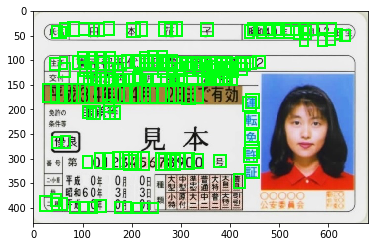

座標： [(1265, 1204), (1401, 1440)]
座標： [(2345, 1526), (2507, 1738)]
座標： [(2085, 995), (2185, 1147)]
座標： [(1166, 1203), (1301, 1438)]
座標： [(1372, 1206), (1504, 1440)]
座標： [(1480, 1207), (1612, 1439)]
座標： [(333, 1459), (426, 1620)]
座標： [(2066, 904), (2174, 1065)]
座標： [(2338, 1259), (2492, 1450)]
座標： [(1982, 995), (2080, 1148)]
座標： [(627, 1201), (764, 1429)]
座標： [(1966, 903), (2072, 1065)]
座標： [(1049, 1205), (1181, 1437)]
座標： [(2025, 1919), (2144, 2077)]
座標： [(2095, 1923), (2209, 2095)]
座標： [(843, 1204), (982, 1433)]
座標： [(1875, 990), (1974, 1144)]
座標： [(946, 1205), (1080, 1435)]
座標： [(744, 1203), (883, 1432)]
座標： [(1860, 902), (1968, 1067)]
座標： [(1581, 1207), (1716, 1439)]
座標： [(526, 1202), (666, 1425)]
座標： [(2166, 981), (2274, 1139)]
座標： [(2128, 991), (2239, 1161)]
座標： [(213, 2375), (332, 2534)]
座標： [(2825, 559), (2926, 729)]
座標： [(2442, 528), (2553, 710)]
座標： [(1070, 528), (1205, 713)]
座標： [(2333, 2067), (2498, 2267)]
座標： [(1689, 1207), (1829, 1440)]
座標： [(1459, 991), (1562, 1143)]
座標： [

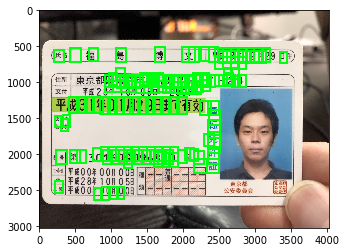

座標： [(520, 41), (534, 60)]
座標： [(312, 249), (329, 269)]
座標： [(414, 44), (428, 64)]
座標： [(75, 251), (95, 274)]
座標： [(357, 183), (380, 209)]
座標： [(447, 44), (462, 63)]
座標： [(195, 140), (214, 172)]
座標： [(428, 44), (443, 64)]
座標： [(181, 140), (199, 172)]
座標： [(135, 140), (155, 172)]
座標： [(255, 141), (274, 172)]
座標： [(241, 140), (260, 172)]
座標： [(38, 40), (54, 60)]
座標： [(211, 140), (229, 172)]
座標： [(79, 42), (98, 64)]
座標： [(182, 245), (197, 272)]
座標： [(227, 140), (245, 172)]
座標： [(462, 43), (476, 64)]
座標： [(149, 140), (167, 172)]
座標： [(357, 241), (380, 266)]
座標： [(509, 41), (521, 60)]
座標： [(167, 245), (182, 272)]
座標： [(197, 244), (212, 273)]
座標： [(271, 141), (289, 171)]
座標： [(242, 245), (258, 273)]
座標： [(360, 210), (381, 235)]
座標： [(212, 244), (228, 273)]
座標： [(400, 44), (414, 64)]
座標： [(226, 244), (243, 273)]
座標： [(187, 251), (203, 276)]
座標： [(242, 44), (260, 64)]
座標： [(173, 251), (188, 276)]
座標： [(167, 140), (184, 171)]
座標： [(130, 43), (152, 63)]
座標： [(357, 269), (381, 293)]
座標： [(136, 24

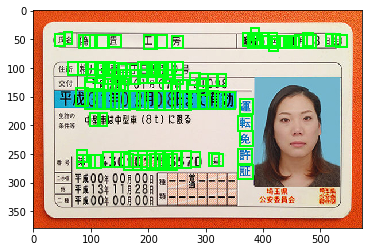

座標： [(2153, 1908), (2268, 2070)]
座標： [(2356, 1371), (2510, 1593)]
座標： [(2336, 1293), (2493, 1513)]
座標： [(1175, 2683), (1291, 2868)]
座標： [(1392, 795), (1518, 1011)]
座標： [(1630, 2066), (1752, 2266)]
座標： [(1307, 2156), (1419, 2352)]
座標： [(2320, 1209), (2476, 1432)]
座標： [(2230, 1912), (2339, 2084)]
座標： [(1525, 2089), (1638, 2290)]
座標： [(979, 2229), (1094, 2426)]
座標： [(1277, 2669), (1390, 2861)]
座標： [(1778, 621), (1932, 842)]
座標： [(1941, 1915), (2045, 2087)]
座標： [(1279, 2104), (1389, 2330)]
座標： [(1387, 2089), (1501, 2319)]
座標： [(2441, 478), (2563, 667)]
座標： [(1100, 2220), (1215, 2409)]
座標： [(1720, 1969), (1825, 2172)]
座標： [(1419, 2137), (1536, 2325)]
座標： [(2386, 1587), (2533, 1809)]
座標： [(1598, 2020), (1711, 2247)]
座標： [(2659, 383), (2772, 576)]
座標： [(1745, 2024), (1857, 2225)]
座標： [(1053, 1302), (1171, 1470)]
座標： [(2108, 539), (2250, 755)]
座標： [(1832, 2007), (1945, 2202)]
座標： [(2029, 1948), (2140, 2124)]
座標： [(1702, 2058), (1829, 2270)]
座標： [(1210, 2178), (1318, 2374)]
座標： [(2473, 1906), (

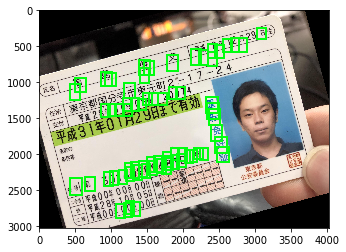

In [90]:
#  imagesは検知させたい画像でiはその画像に番号振ったもの
zahyou = []
for num, img in enumerate(images):
    # Parse the outputs.
    #  これは予測したもの全てのそれぞれの値が出てしまう！！ラベルである確率が低いものまで全て入ってしまってる
    det_label = results[num][:, 0]
    #  det_confは確率 softmax使ってるから。そのラベルである確率
    det_conf = results[num][:, 1]
    det_xmin = results[num][:, 2]
    det_ymin = results[num][:, 3]
    det_xmax = results[num][:, 4]
    det_ymax = results[num][:, 5]
    

    # Get detections with confidence higher than 0.6.
    #  確率が６０％以上のものだけのインデックス番号を取り出す
    # →６０％以上の[label, confidence, xmin, ymin, xmax, ymax]＝top_indicesを取り出す
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]
    
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]
    
    
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]
        
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]
          
        
    if len(top_indices) <= 50:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.23]
    
    #if len(top_indices) <= 50:
    #    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.18]
        
    

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

#  top_confで６０％以上のラベルであろう数字が一番確率が高い順から入ってる！！top_conf.shape[0]は見つけだした枠の数の分だけの確率が入ってる。
# ６０％以上で検知できた物体が４つあるなら４とでる
# top_conf.shape[0]には検知した物体の数＝枠の数の分だけの確率が格納されてる
    for i in range(top_conf.shape[0]):
        
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        # xmax ymaxが右下の座標
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        
     
        zahyou.append({'{}枚目'.format(num+1): [(xmin,ymin),(xmax , ymin ) ,(xmin, ymax) ,(xmax ,ymax)] })
        score = top_conf[i]
        label_name = int(top_label_indices[i])
        #label_name = voc_classes[label - 1]
        #  表示する文字→確率とラベルの名前catとか
        #display_txt = '{:0.2f}, {}'.format(score, label_name)
        display_txt=None
        
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        zahyou =  [ (xmin, ymin), (xmax,ymax) ]
        color = colors[label_name]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        
        print('座標：',zahyou)
      
    

    plt.show()
#print(zahyou)

zahyou: [(216, 150), (242, 184)]
zahyou: [(161, 151), (188, 184)]
zahyou: [(178, 151), (203, 184)]
zahyou: [(286, 150), (314, 185)]
zahyou: [(199, 150), (225, 184)]
zahyou: [(230, 150), (255, 184)]
zahyou: [(144, 150), (171, 184)]
zahyou: [(266, 23), (292, 48)]
zahyou: [(271, 150), (297, 184)]
zahyou: [(86, 93), (107, 119)]
zahyou: [(72, 150), (102, 185)]
zahyou: [(188, 23), (216, 48)]
zahyou: [(368, 294), (394, 321)]
zahyou: [(117, 25), (140, 48)]
zahyou: [(103, 96), (125, 123)]
zahyou: [(112, 389), (130, 410)]
zahyou: [(128, 388), (146, 410)]
zahyou: [(90, 150), (117, 184)]
zahyou: [(344, 390), (360, 409)]
zahyou: [(220, 389), (236, 409)]
zahyou: [(332, 93), (353, 118)]
zahyou: [(303, 150), (331, 186)]
zahyou: [(362, 390), (378, 410)]
zahyou: [(202, 92), (221, 119)]
zahyou: [(314, 93), (334, 118)]
zahyou: [(167, 389), (183, 410)]
zahyou: [(53, 149), (83, 184)]


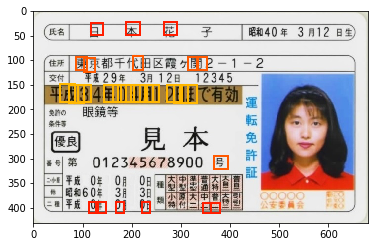

zahyou: [(196, 1227), (363, 1403)]
zahyou: [(533, 1223), (667, 1417)]
zahyou: [(642, 1072), (746, 1210)]
zahyou: [(1856, 1046), (1952, 1186)]
zahyou: [(1752, 1061), (1843, 1193)]
zahyou: [(1637, 1073), (1727, 1202)]
zahyou: [(3225, 493), (3319, 650)]
zahyou: [(767, 1077), (865, 1211)]
zahyou: [(765, 1226), (907, 1420)]
zahyou: [(1051, 559), (1214, 725)]
zahyou: [(895, 1072), (988, 1201)]
zahyou: [(420, 1213), (567, 1420)]
zahyou: [(832, 1230), (976, 1422)]
zahyou: [(1550, 1081), (1640, 1207)]
zahyou: [(2355, 1420), (2486, 1570)]
zahyou: [(2082, 1021), (2190, 1167)]
zahyou: [(3309, 485), (3405, 652)]
zahyou: [(2388, 1338), (2536, 1479)]
zahyou: [(1964, 1034), (2066, 1179)]
zahyou: [(583, 1056), (689, 1192)]
zahyou: [(2150, 1005), (2263, 1154)]
zahyou: [(2047, 920), (2158, 1063)]
zahyou: [(664, 1225), (795, 1417)]
zahyou: [(1007, 1063), (1096, 1192)]
zahyou: [(1948, 920), (2058, 1060)]
zahyou: [(1864, 921), (1979, 1072)]
zahyou: [(3130, 492), (3225, 649)]
zahyou: [(2334, 1495), (2483, 16

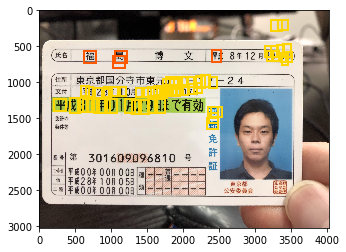

zahyou: [(133, 139), (155, 172)]
zahyou: [(147, 139), (167, 173)]
zahyou: [(121, 139), (142, 172)]
zahyou: [(193, 138), (214, 173)]
zahyou: [(180, 138), (200, 173)]
zahyou: [(209, 138), (229, 173)]
zahyou: [(240, 139), (261, 173)]
zahyou: [(105, 138), (124, 172)]
zahyou: [(87, 139), (108, 172)]
zahyou: [(225, 139), (245, 173)]
zahyou: [(253, 139), (274, 172)]
zahyou: [(165, 138), (184, 173)]


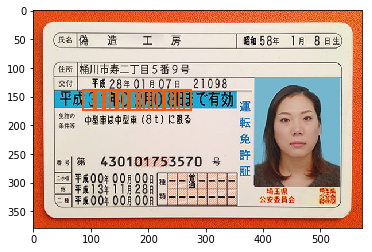

zahyou: [(2310, 1126), (2481, 1296)]
zahyou: [(1804, 2050), (1925, 2253)]
zahyou: [(2434, 1794), (2604, 1933)]
zahyou: [(1303, 1261), (1411, 1394)]
zahyou: [(1362, 1254), (1478, 1374)]
zahyou: [(2987, 196), (3094, 341)]
zahyou: [(1192, 1281), (1299, 1411)]
zahyou: [(1903, 2046), (2032, 2258)]
zahyou: [(880, 1370), (985, 1491)]
zahyou: [(643, 1505), (775, 1667)]
zahyou: [(1396, 1265), (1507, 1410)]
zahyou: [(758, 1424), (874, 1541)]
zahyou: [(1255, 1280), (1373, 1394)]
zahyou: [(856, 1426), (974, 1585)]
zahyou: [(1555, 1195), (1677, 1309)]
zahyou: [(2920, 211), (3024, 343)]
zahyou: [(1166, 1344), (1289, 1503)]
zahyou: [(2300, 1193), (2484, 1361)]
zahyou: [(732, 1496), (876, 1676)]
zahyou: [(674, 1437), (781, 1567)]
zahyou: [(2398, 1607), (2546, 1753)]
zahyou: [(1368, 1331), (1508, 1519)]
zahyou: [(831, 1486), (979, 1676)]
zahyou: [(1482, 1264), (1605, 1424)]
zahyou: [(972, 1355), (1078, 1485)]
zahyou: [(2332, 1403), (2484, 1549)]
zahyou: [(1264, 1340), (1395, 1513)]
zahyou: [(1449, 1229

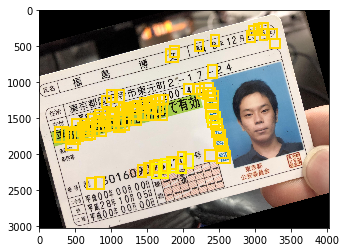

In [75]:
# imagesはnumpy arrayのラベル用に振り分けられた画像本体が入っている
#print(len(images))


for num, img in enumerate(images):
    # Parse the outputs.
    #  画像ごとの[label, confidence, xmin, ymin, xmax, ymax]を[i]で取り出し、その中の欲しい情報だけさらにスライスで抜き取る
    #   ラベルの数は８１ 



    det_label = results[num][:, 0]
    det_conf = results[num][:, 1]
    det_xmin = results[num][:, 2]
    det_ymin = results[num][:, 3]
    det_xmax = results[num][:, 4]
    det_ymax = results[num][:, 5]



    # Get detections with confidence higher than 0.6.
    # それぞれ画像の格納されてる順にラベルや確率や座標をまとめたわけだが、確率が６０％以上のインデックス番号を抜き出す
    
    #top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.1]
    #top_indices = [i for i, conf in enumerate(det_conf) ]
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.4]
    
    if top_indices == []:
        top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.2]
    
    #print(top_indices)
#  ６０％以上の確率のラベルや座標だけが残る
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    

    #  表示する色を指定してるだけ、４色(0, 1, 4)だったが一番後ろの数字を増やせばエラーなくなる, 一番後ろの数字を変えることで色が変わる
    colors = plt.cm.hsv(np.linspace(0, 1, 50)).tolist()
    #print(len(colors))

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    # 一番確率が高いものから格納されてるから、インデックス番号０→一番確率が高いものだけを取り出す。→一番確率が高い左上の座標と右上の座標を取り出す
    #  一番高い確率＝スコアを出す
    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
       
        
        score = top_conf[i]
        #  この物体は何かを判定する。一番確率高い所のラベルを抜き出す
        label = int(top_label_indices[i])
        
        #  ラベルは、XML_pklのワンホットベクトルの上から順にリストを作って行く 
        label_name = ['A' , 'I' , 'U', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else', ' else']
        
        len(label_name)
        label_name = label_name[label]

#         label_name = voc_classes[label - 1]
        #label_name = {0: ,1: ,2:}
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        
        zahyou =  [ (xmin, ymin), (xmax,ymax) ]
        #print(label)
        #colors = np.array(colors)
        #print(colors.shape)
        


        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
        #plt.gca().add_patch( plt.Rectangle(xy=[xmin, ymax], width=0.5, height=0.5, fill=False, edgecolor='red') )
        
        print('zahyou:',zahyou)       
    plt.show()
        #zahyou = [(xmin,ymin),(xmax , ymin ) ,(xmin, ymax) ,(xmax ,ymax)]
       
        
             

    
    
#  予測があ、い、う、その他のどれかに分類するようにしている。あ→A  　い→I  　う→U  　その他→else

#  文字の分類の精度は低いものの、バウンディングボックスによる認識はできている。画像の下に座標を出力